In [16]:
import math
import torch
from torch import nn
from d2l import torch as d2l

# Self-attention

In [17]:
num_hiddens, num_heads = 100, 5

attention = d2l.MultiHeadAttention(key_size=num_hiddens, query_size=num_hiddens, value_size=num_hiddens, num_hiddens=num_hiddens, num_heads=num_heads, dropout=0.5, bias=False)

attention.eval()

c:\Users\10331\anaconda3\envs\pt\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): LazyLinear(in_features=0, out_features=100, bias=False)
  (W_k): LazyLinear(in_features=0, out_features=100, bias=False)
  (W_v): LazyLinear(in_features=0, out_features=100, bias=False)
  (W_o): LazyLinear(in_features=0, out_features=100, bias=False)
)

In [18]:
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape # final_shape should be (batch_size, num_queries, num_hiddens)

torch.Size([2, 4, 100])

# Positional_encoding

The input embedding matrix is $X\in \mathbb{R}^{n \times d}$ <br>
The positional embedding matrix is $P\in \mathbb{R}^{n \times d}$ <br>
The positional encoding outputs $X + P$ <br>
Below, $i$ denotes the $i^{th}$ row and $j$ denotes the $j^{th}$ column of $P$

$$p_{i, 2j} = sin(\frac{i}{10000^{2j/d}})$$
$$p_{i, 2j+1} = cos(\frac{i}{10000^{2j/d}}) $$

In [19]:
class PositionalEncoding(nn.Module):
	"""Position encoding X+P with dropout"""

	def __init__(self, num_hiddens, dropout, max_len=1000):
		super(PositionalEncoding, self).__init__()
		self.dropout = nn.Dropout(dropout)

		# create a single batch_size 1, long enough P, longer than sequence length
		self.P = torch.zeros((1, max_len, num_hiddens))
		X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32)/num_hiddens)
		self.P[:, :, 0::2] = torch.sin(X)
		self.P[:, :, 1::2] = torch.cos(X)

	def forward(self, X):
		X = X + self.P[:, :X.shape[1], :].to(X.device)
		return self.dropout(X)

In [20]:
# test
encoding_dim, num_steps = 32, 60 
pos_encoding = PositionalEncoding(num_hiddens = encoding_dim, dropout=0.0)
pos_encoding.eval()

PositionalEncoding(
  (dropout): Dropout(p=0.0, inplace=False)
)

4


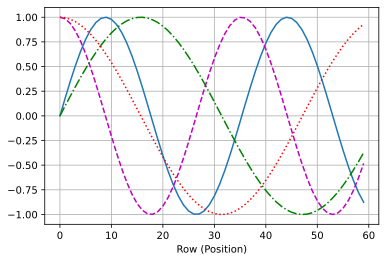

In [27]:
X_pos_encoded = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X_pos_encoded.shape[1], :]

# Below is for 1 data, all position, how 6-10 featuers_steps being encoded
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (Position)', figsize=(6, 4))